In [36]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from tqdm.notebook import tqdm

from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u


PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# load Teimoorinia preds

In [6]:
t17 = ascii.read(f'{PATH}/data/Teimoorinia+17.csv')

In [7]:
t17 = t17.to_pandas()

In [21]:
t17.head()

,SDSS,RAJ2000,DEJ2000,z,logM*,logMHI/M*,Cfgas,PR,sigmafitN,sigmafit,sigmafgas,Sloan
0,NaN,deg,deg,NaN,[Msun],[-],NaN,NaN,NaN,NaN,NaN,NaN
1,------------------,------------,------------,---------,------,--------,--------,--------,--------,--------,--------,-----
2,587739406797045937,224.23624990,+28.14417443,0.081533,10.148,-0.30544,0.29869,0.43821,0.59882,0.05893,0.41720,Sloan
3,587725040098672781,195.45809990,-02.78820341,0.083640,11.092,-1.14553,0.04102,0.07259,0.49647,0.12357,0.73594,Sloan
4,587724233714892940,018.24107346,+15.39561309,0.043656,9.913,0.01798,0.00529,0.01287,0.36143,0.32833,0.79948,Sloan


In [22]:
t17 = t17.loc[2:]

In [24]:
t17 = t17.astype(
    {
        'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
        'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
        'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
    }
)

In [25]:
t17.sample(3)

,SDSS,RAJ2000,DEJ2000,z,logM*,logMHI/M*,Cfgas,PR,sigmafitN,sigmafit,sigmafgas,Sloan
342033,587729774218379500,204.822275,-1.846861,0.089303,11.353,-1.31125,0.13222,0.23917,0.48567,0.13362,0.59712,Sloan
211803,587736547387965778,232.354620,5.893307,0.076926,10.706,-0.59247,0.50483,0.60881,0.72847,0.02306,0.28857,Sloan
251375,587724232102576222,14.159512,14.361135,0.083559,10.648,-0.95064,0.31663,0.38185,0.72847,0.02306,0.40252,Sloan


In [26]:
t17_mini = t17.sample(1000)

# NIBLES sample

In [35]:
nibles_preds = pd.read_csv(f'{PATH}/results/nibles/nibles_clean_results.csv', index_col=0) # alfalfa only preds
nibles = pd.read_csv(f'{PATH}/data/NIBLES_data.csv')
nibles.head()

,nibles_id,ra,dec,z,logMstar,logMHI,logsSFR,W50,peakSNR,logfgas
0,1,0.008750,15.881694,0.020000,9.74,9.06,-9.96,214,3.4,-0.67
1,2,0.053333,1.120194,0.024653,10.18,9.82,-10.15,233,5.0,-0.36
2,4,0.264958,14.580167,0.005713,6.76,7.56,-8.37,40,4.2,0.80
3,5,0.391458,15.081556,0.021173,9.57,9.53,-9.75,117,6.1,-0.03
4,6,0.561542,14.487775,0.017103,8.67,9.41,-9.77,178,6.1,0.74


In [41]:
ni = nibles.join(nibles_preds, on='nibles_id', how='inner')
ni.sample(3)

,nibles_id,ra,dec,z,logMstar,logMHI,logsSFR,W50,peakSNR,logfgas,fgas_true,fgas_pred
361,621,124.803167,20.510722,0.016593,10.80,10.05,-12.41,405,13.6,-0.75,-0.75,-1.214027
1186,2075,213.716667,14.125861,0.016577,10.47,9.98,-10.60,363,17.3,-0.49,-0.49,-0.207609
511,879,143.511667,10.108694,0.010480,10.37,8.95,-11.87,296,6.9,-1.42,-1.42,-1.324414


In [77]:
ni_coords = SkyCoord(ni.ra, ni.dec, unit=u.deg)
t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [97]:
cutoff = 1 / 3600 # deg
idx_t17, idx_ni, _, _ = ni_coords.search_around_sky(t17_coords, cutoff*u.deg)

In [98]:
# make sure no duplicates
len(list(idx_ni)), len(set(idx_ni)), len(list(idx_t17)), len(set(idx_t17))

(178, 178, 178, 178)

In [99]:
t17_x_ni = t17.iloc[idx_t17]
ni_x_t17 = ni.iloc[idx_ni]

In [104]:
ni_x_t17.reset_index(drop=True, inplace=True)
t17_x_ni.reset_index(inplace=True)

# rename columns for convenience
t17_x_ni = t17_x_ni.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

ni_x_t17 = ni_x_t17.join(t17_x_ni)


In [112]:
ni_x_t17.columns

Index(['nibles_id', 'ra', 'dec', 'z', 'logMstar', 'logMHI', 'logsSFR', 'W50',
       'peakSNR', 'logfgas', 'fgas_true', 'fgas_pred', 'index', 'SDSS',
       'RAJ2000', 'DEJ2000', 'z_t17', 'logM*', 'fgas_t17', 'Cfgas', 'PR',
       'sigmafitN', 'sigmafit', 'sigmafgas', 'Sloan'],
      dtype='object')

(array([ 2., 10., 95., 54.,  9.,  4.,  2.,  0.,  1.,  1.]),
 array([-51.7 , -28.41,  -5.12,  18.17,  41.46,  64.75,  88.04, 111.33, 134.62, 157.91, 181.2 ]),
 <a list of 10 Patch objects>)

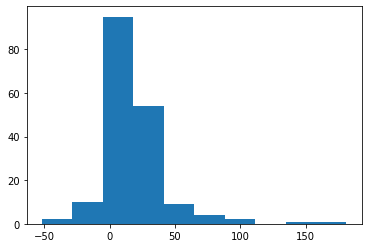

In [110]:
plt.hist(3e5 * (ni_x_t17.z_t17 - ni_x_t17.z)) # generally < 100 km/s

In [141]:
# drop anything with |delta v > 50 km/s|
print(sum(3e5*np.abs(ni_x_t17.z_t17 - ni_x_t17.z) > 50))
ni_x_t17 = ni_x_t17[3e5*np.abs(ni_x_t17.z_t17 - ni_x_t17.z) <= 50]

13


## Without any `Cfgas` cuts

In [142]:
rmse_ours = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_t17)**2)**0.5

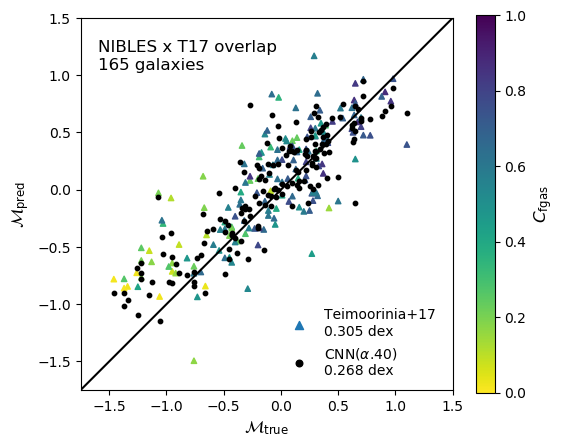

In [212]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_t17, c=ni_x_t17.Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0, vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-1.75, 1.5)
plt.ylim(-1.75, 1.5)

plt.text(-1.6, 1.05, 'NIBLES x T17 overlap' '\n' f'{len(ni_x_t17)} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [190]:
# note that the RMSE is not equal to the std:
print(np.std(ni_x_t17.fgas_true - ni_x_t17.fgas_pred))
print(np.std(ni_x_t17.fgas_true - ni_x_t17.fgas_t17))

0.27216811925005857
0.3433631120336082


## Implement `Cfgas` > 0.5 and $\sigma_{\rm fit}$ < 0.1 cuts

In [195]:
cut = (ni_x_t17.sigmafit < 0.1) & (ni_x_t17.Cfgas > 0.5)
sum(cut)

104

In [196]:
rmse_ours = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_t17)**2)**0.5

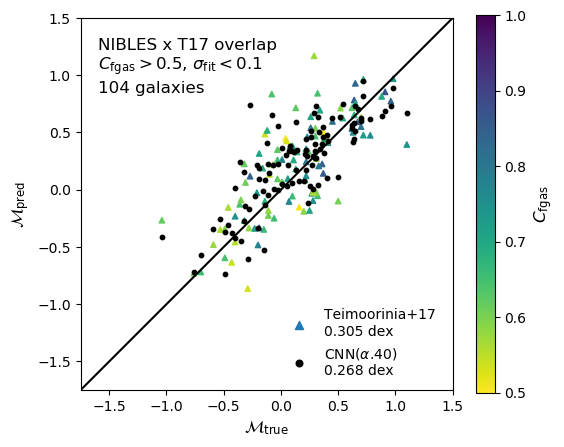

In [213]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_t17, c=ni_x_t17[cut].Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0.5, vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-1.75, 1.5)
plt.ylim(-1.75, 1.5)

plt.text(-1.6, 0.85, 'NIBLES x T17 overlap\n' r'$C_{\rm fgas} > 0.5$, $\sigma_{\rm fit} < 0.1$' '\n' f'{len(ni_x_t17[cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [208]:
print(np.std(ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_pred))
print(np.std(ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_t17))

0.250569480235115
0.29846096878428524


# Compare with ALFALFA+xGASS CNN

In [218]:
nibles_preds = pd.read_csv(f'{PATH}/results/nibles/nibles_clean_combined-results.csv', index_col=0)

In [219]:
ni = pd.read_csv(f'{PATH}/data/NIBLES_data.csv').join(nibles_preds, on='nibles_id', how='inner')
ni_coords = SkyCoord(ni.ra, ni.dec, unit=u.deg)
idx_t17, idx_ni, _, _ = ni_coords.search_around_sky(t17_coords, 1/3600*u.deg)

In [220]:
t17_x_ni = t17.iloc[idx_t17]
ni_x_t17 = ni.iloc[idx_ni]

In [221]:
ni_x_t17.reset_index(drop=True, inplace=True)
t17_x_ni.reset_index(inplace=True)

t17_x_ni = t17_x_ni.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
ni_x_t17 = ni_x_t17.join(t17_x_ni)

ni_x_t17 = ni_x_t17[3e5*np.abs(ni_x_t17.z_t17 - ni_x_t17.z) <= 50] # velocity cut

In [228]:
rmse_ours = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_t17)**2)**0.5

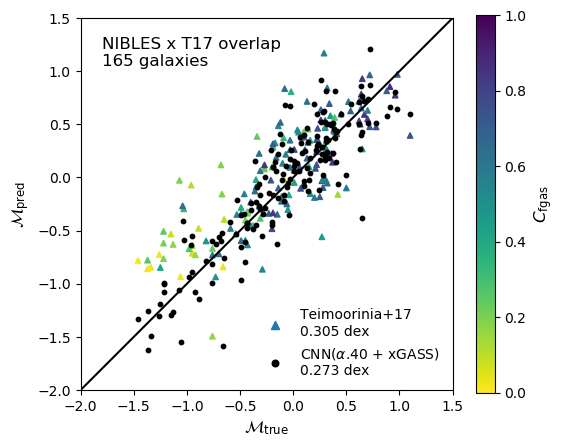

In [234]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_t17, c=ni_x_t17.Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0., vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40 + xGASS)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2, 1.5)
plt.ylim(-2, 1.5)

plt.text(-1.8, 1.05, 'NIBLES x T17 overlap\n' f'{len(ni_x_t17)} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [230]:
rmse_ours = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_t17)**2)**0.5

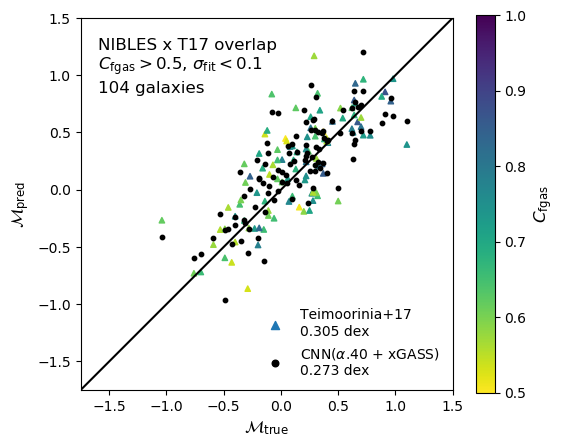

In [231]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_t17, c=ni_x_t17[cut].Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0.5, vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40 + xGASS)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-1.75, 1.5)
plt.ylim(-1.75, 1.5)

plt.text(-1.6, 0.85, 'NIBLES x T17 overlap\n' r'$C_{\rm fgas} > 0.5$, $\sigma_{\rm fit} < 0.1$' '\n' f'{len(ni_x_t17[cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

## Ensembling the two sets of predictions?

In [252]:
nibles_preds = pd.read_csv(
    f'{PATH}/results/nibles/nibles_clean_results.csv', index_col=0
).join(
    pd.read_csv(
        f'{PATH}/results/nibles/nibles_clean_combined-results.csv', index_col=0, usecols=(0,2)), 
    rsuffix='_combined'
)

In [253]:
nibles_preds['fgas_pred'] = np.mean([nibles_preds.fgas_pred, nibles_preds.fgas_pred_combined], axis=0)
nibles_preds.sample(3)

,fgas_true,fgas_pred,fgas_pred_combined
nibles_id,,,
862,-1.03,-1.180078,-1.138234
1232,-0.12,0.293570,0.276115
661,-0.05,0.332563,0.266408


In [254]:
ni = pd.read_csv(f'{PATH}/data/NIBLES_data.csv').join(nibles_preds, on='nibles_id', how='inner')
ni_coords = SkyCoord(ni.ra, ni.dec, unit=u.deg)
idx_t17, idx_ni, _, _ = ni_coords.search_around_sky(t17_coords, 1/3600*u.deg)

In [255]:
t17_x_ni = t17.iloc[idx_t17]
ni_x_t17 = ni.iloc[idx_ni]

In [256]:
ni_x_t17.reset_index(drop=True, inplace=True)
t17_x_ni.reset_index(inplace=True)

t17_x_ni = t17_x_ni.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
ni_x_t17 = ni_x_t17.join(t17_x_ni)

ni_x_t17 = ni_x_t17[3e5*np.abs(ni_x_t17.z_t17 - ni_x_t17.z) <= 50] # velocity cut

In [257]:
rmse_ours = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17.fgas_true - ni_x_t17.fgas_t17)**2)**0.5

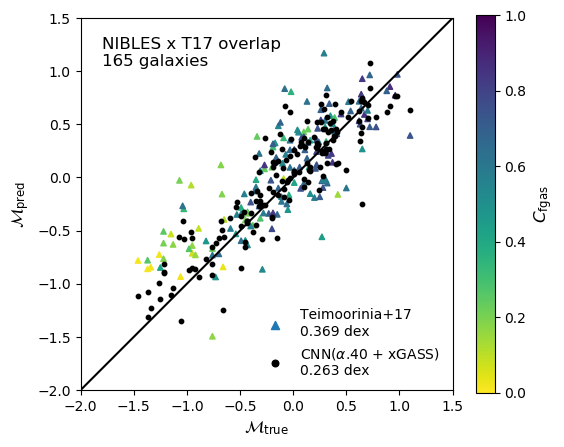

In [258]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_t17, c=ni_x_t17.Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0., vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17.fgas_true, ni_x_t17.fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40 + xGASS)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2, 1.5)
plt.ylim(-2, 1.5)

plt.text(-1.8, 1.05, 'NIBLES x T17 overlap\n' f'{len(ni_x_t17)} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [259]:
rmse_ours = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_pred)**2)**0.5
rmse_t17 = np.mean((ni_x_t17[cut].fgas_true - ni_x_t17[cut].fgas_t17)**2)**0.5

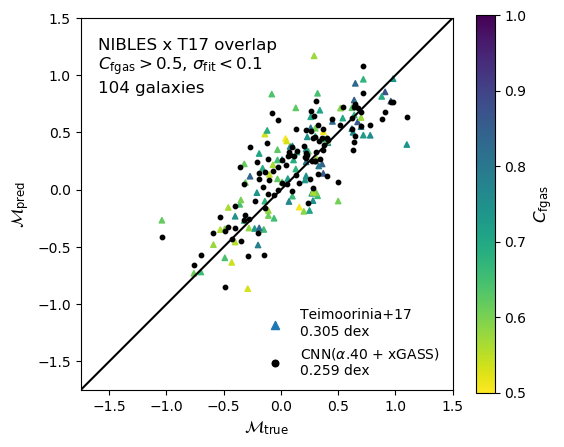

In [260]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_t17, c=ni_x_t17[cut].Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0.5, vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(ni_x_t17[cut].fgas_true, ni_x_t17[cut].fgas_pred, c='k', s=10, label=r'CNN($\alpha$.40 + xGASS)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-1.75, 1.5)
plt.ylim(-1.75, 1.5)

plt.text(-1.6, 0.85, 'NIBLES x T17 overlap\n' r'$C_{\rm fgas} > 0.5$, $\sigma_{\rm fit} < 0.1$' '\n' f'{len(ni_x_t17[cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

# Summary of what I did:

- use existing CNN trained on xGASS + ALFALFA, predict on all NIBLES imaging that passes cleaning cuts -> 941 galaxies (see notebooks **00**, **01**)
- download Teimoorinia+17 catalog from CDS, crossmatch with our predictions catalog to within 0.5 arcsec and 50 km/s -> 165 galaxies
- cut T+17 catalog to those with Cfgas > 0.5 and sigmafit < 0.1 -> 104 galaxies
- compare my predictions (0.27 dex) with theirs (0.30 dex)

Potential critiques: 
- we're still using cuts defined by T+17 and their photometry/pre-analysis -> true, although this is as close to an apples to apples comparison as we can get
- can you make confident predictions (i.e., via "pattern recognition") on your own? -> in some sense, yes, we can select galaxies that we expect to be ALFALFA-like (see notebook **40**).